### Pair: MOREIRA Luiz Fernando & SANGINETO Marina

# Graph Learning

## Lab 7: Graph Neural Networks

In this lab, you will learn to classify nodes using a graph neural network (GNN).

## Import

In [1]:
!pip install scikit-network
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
from sknetwork.classification import get_accuracy_score
from sknetwork.data import load_netset
from sknetwork.embedding import Spectral
from sknetwork.gnn import GNNClassifier
from sknetwork.utils import directed2undirected

from sklearn.manifold import TSNE

## Data

We will work on the following datasets (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Cora (directed graph + bipartite graph)
* WikiVitals (directed graph + bipartite graph)

Both datasets are graphs with node features (given by the bipartite graph) and ground-truth labels.

In [3]:
cora = load_netset('cora')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


In [4]:
def visualize_embedding(embedding, labels, size=(6,6)):
    """Visualize embedding in 2 dimensions using TSNE. """
    print("Computing TSNE...")
    tsne = TSNE(random_state=8).fit_transform(embedding)
    fig, ax = plt.subplots(1, 1, figsize=size)
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, s=50, cmap='hsv')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## 1. Cora

We start with the Cora dataset. We check the embedding of the nodes before and after learning, and the impact of the GNN architecture on accuracy.

In [5]:
dataset = cora

In [6]:
adjacency = dataset.adjacency
features = dataset.biadjacency
labels_true = dataset.labels

In [7]:
# we use undirected graphs
adjacency = directed2undirected(adjacency)

## To do

Consider a GNN with a single hidden layer of dimension 16.

* Run a single forward pass on the data, without learning.
* Display the embedding provided by the hidden layer.

In [8]:
hidden_dim = 16

In [9]:
n_labels = len(set(labels_true))

In [10]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [11]:
gnn

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [12]:
output = gnn.forward(adjacency, features)

In [13]:
# hidden layer
embedding = gnn.layers[0].embedding

Computing TSNE...


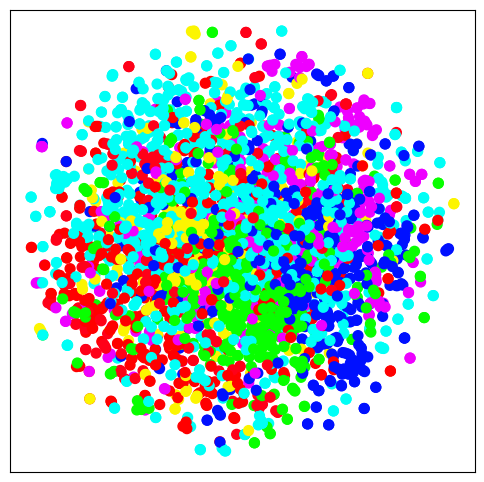

In [14]:
visualize_embedding(embedding, labels_true)

## To do

We now train the GNN.

* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification on the train and test sets.
* Give the total number of parameters.
* Display the embedding provided by the hidden layer.

In [15]:
# train / test split
ratio_train = 0.5
labels = labels_true.copy()
mask_train = np.random.random(size=len(labels)) < ratio_train
mask_test = ~mask_train
labels[mask_test] = -1

In [16]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 2.005, train accuracy: 0.121
In epoch  10, loss: 1.693, train accuracy: 0.586
In epoch  20, loss: 1.468, train accuracy: 0.804
In epoch  30, loss: 1.316, train accuracy: 0.911
In epoch  40, loss: 1.241, train accuracy: 0.966
In epoch  50, loss: 1.209, train accuracy: 0.975
In epoch  60, loss: 1.193, train accuracy: 0.984
In epoch  70, loss: 1.185, train accuracy: 0.990
In epoch  80, loss: 1.180, train accuracy: 0.993
In epoch  90, loss: 1.177, train accuracy: 0.994


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [17]:
labels_pred = gnn.predict()

In [18]:
train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9962797619047619
Test accuracy: 0.8130498533724341


In [19]:
# Total number of parameters
weights = [layer.weight for layer in gnn.layers]
biases = [layer.bias for layer in gnn.layers]
total_params = sum(w.size for w in weights) + sum(b.size for b in biases)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 23063


Computing TSNE...


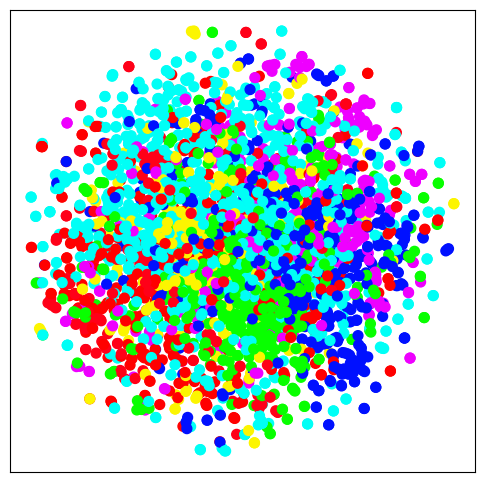

In [20]:
visualize_embedding(embedding, labels_pred)

## To do

* Retrain the GNN with an empty graph.
* Compare the accuracy of the classification with that of the previous model.
* Comment the results. <br>What is the learning model?

**Answer:** By training the GNN model with an empty graph, the network don't get to have samples to understand the dataset. In this way the model gets quickly overfited by the empty training set and thus the test accuracy scores way worst ( $64.81\%$ compared to $79.65\%$)

In [21]:
empty = sparse.csr_matrix(adjacency.shape)

In [22]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)
gnn.fit(empty, features, labels)
labels_pred = gnn.predict()

In epoch   0, loss: 1.916, train accuracy: 0.226
In epoch  10, loss: 1.761, train accuracy: 0.475
In epoch  20, loss: 1.542, train accuracy: 0.772
In epoch  30, loss: 1.374, train accuracy: 0.905
In epoch  40, loss: 1.272, train accuracy: 0.964
In epoch  50, loss: 1.223, train accuracy: 0.984
In epoch  60, loss: 1.200, train accuracy: 0.994
In epoch  70, loss: 1.188, train accuracy: 0.997
In epoch  80, loss: 1.181, train accuracy: 0.998
In epoch  90, loss: 1.178, train accuracy: 0.999


In [23]:
train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9985119047619048
Test accuracy: 0.6532258064516129


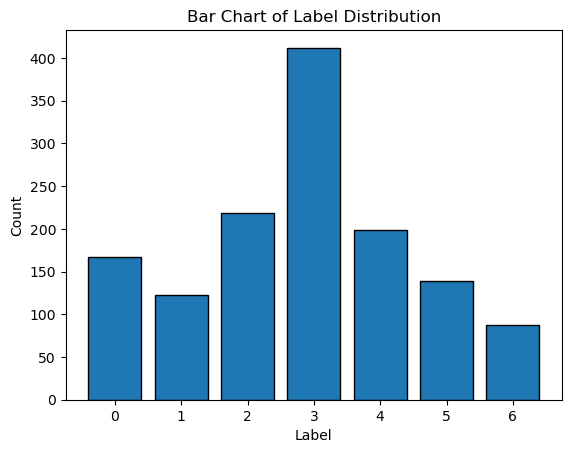

In [24]:
# Distribution of the training with empty graph
unique_labels, counts = np.unique(labels_pred[mask_train], return_counts=True)
plt.bar(unique_labels, counts, edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Chart of Label Distribution')
plt.show()

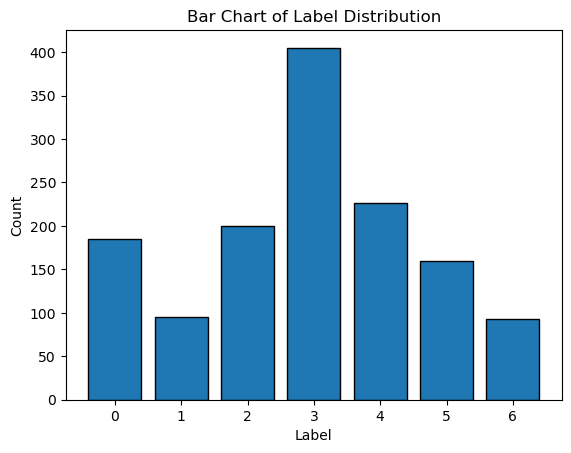

In [25]:
# Distribution of the dataset
unique_labels, counts = np.unique(labels_true[mask_test], return_counts=True)
plt.bar(unique_labels, counts, edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Chart of Label Distribution')
plt.show()

## To do

We now consider a hidden layer of dimension 32.

* Retrain the GNN (with the graph).
* Give the accuracy of the classification and the number of parameters.
* Comment the results.
**Answers:** When using twice the number of hidden layer the total number of parameters almost doubles as well, while the accuracy gets to be better by only $4\%$ more. 

In [26]:
hidden_dim = 32
n_labels = len(set(labels_true))
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [27]:
# train / test split
ratio_train = 0.5
labels = labels_true.copy()
mask_train = np.random.random(size=len(labels)) < ratio_train
mask_test = ~mask_train
labels[mask_test] = -1

In [28]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 1.945, train accuracy: 0.203
In epoch  10, loss: 1.378, train accuracy: 0.846
In epoch  20, loss: 1.247, train accuracy: 0.961
In epoch  30, loss: 1.203, train accuracy: 0.984
In epoch  40, loss: 1.186, train accuracy: 0.992
In epoch  50, loss: 1.178, train accuracy: 0.996
In epoch  60, loss: 1.175, train accuracy: 0.996
In epoch  70, loss: 1.173, train accuracy: 0.997
In epoch  80, loss: 1.172, train accuracy: 0.997
In epoch  90, loss: 1.171, train accuracy: 0.998


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 32, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [29]:
labels_pred = gnn.predict()

In [30]:
train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9985141158989599
Test accuracy: 0.8237885462555066


In [31]:
# Total number of parameters
weights = [layer.weight for layer in gnn.layers]
biases = [layer.bias for layer in gnn.layers]
total_params = sum(w.size for w in weights) + sum(b.size for b in biases)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 46119


## To do

Finally , we take 2 hidden layers, each of dimension 16.

* Retrain the GNN.
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

**Answer:** By taking two hidden layers we get to have a simmilar value in both accuracy and the total amount of parameters as with one single hidden layer of dimention 16.

In [32]:
hidden_dim = 16
n_labels = len(set(labels_true))
gnn = GNNClassifier(dims=[hidden_dim, hidden_dim, n_labels], verbose=True)

In [33]:
gnn

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [34]:
# train / test split
ratio_train = 0.5
labels = labels_true.copy()
mask_train = np.random.random(size=len(labels)) < ratio_train
mask_test = ~mask_train
labels[mask_test] = -1

In [35]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 2.045, train accuracy: 0.098
In epoch  10, loss: 1.816, train accuracy: 0.337
In epoch  20, loss: 1.697, train accuracy: 0.631
In epoch  30, loss: 1.544, train accuracy: 0.725
In epoch  40, loss: 1.433, train accuracy: 0.817
In epoch  50, loss: 1.359, train accuracy: 0.879
In epoch  60, loss: 1.306, train accuracy: 0.912
In epoch  70, loss: 1.271, train accuracy: 0.929
In epoch  80, loss: 1.248, train accuracy: 0.944
In epoch  90, loss: 1.231, train accuracy: 0.958


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [36]:
labels_pred = gnn.predict()

In [37]:
train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9676934635612322
Test accuracy: 0.7559912854030502


In [38]:
# Total number of parameters
weights = [layer.weight for layer in gnn.layers]
biases = [layer.bias for layer in gnn.layers]
total_params = sum(w.size for w in weights) + sum(b.size for b in biases)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 23335


## 2. Wikivitals

We now focus on Wikivitals. We take the spectral embedding of the article-word bipartite graph as features.

In [39]:
dataset = wikivitals

In [40]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
labels_true = dataset.labels
names_labels = dataset.names_labels

In [41]:
# we consider the graph as undirected
adjacency = directed2undirected(adjacency)

In [42]:
# we use the spectral embedding of the bipartite graph as features
spectral = Spectral(20)
features = spectral.fit_transform(biadjacency)

## To do

We consider a GNN with a single hidden layer of dimension 16.
* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification.
* Display the confusion matrix of the test set.
* Give for each label the 5 articles of the test set classified with the highest confidence.

In [43]:
n_labels = len(set(labels_true))

In [44]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [45]:
# train / test split
ratio_train = 0.5
labels = labels_true.copy()
mask_train = np.random.random(size=len(labels)) < ratio_train
mask_test = ~mask_train
labels[mask_test] = -1

In [46]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 2.384, train accuracy: 0.155
In epoch  10, loss: 2.284, train accuracy: 0.430
In epoch  20, loss: 2.114, train accuracy: 0.631
In epoch  30, loss: 1.969, train accuracy: 0.731
In epoch  40, loss: 1.877, train accuracy: 0.779
In epoch  50, loss: 1.831, train accuracy: 0.794
In epoch  60, loss: 1.811, train accuracy: 0.807
In epoch  70, loss: 1.798, train accuracy: 0.814
In epoch  80, loss: 1.789, train accuracy: 0.818
In epoch  90, loss: 1.784, train accuracy: 0.822


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 11, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [47]:
labels_pred = gnn.predict()

In [48]:
train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.8269270298047277
Test accuracy: 0.8171395258453168


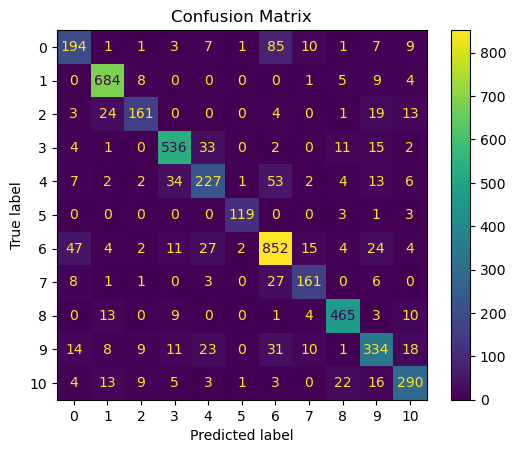

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_true[mask_train], labels_pred[mask_train])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix')
plt.show()

In [50]:
probs = gnn.predict_proba()

In [51]:
from sknetwork.ranking import top_k

prob_test = probs[mask_test]
for label, name in enumerate(np.unique(names_labels)):
    scores = probs[:, label]
    top5 = top_k(scores, 5)
    print(name,':')
    for article in top5:
        print(names[article])
    print("-"*30)

Arts :
Painting
Theatre
Printmaking
Conceptual art
Commedia dell'arte
------------------------------
Biological and health sciences :
Taxonomy (biology)
Animal
Chordate
Species
Bird
------------------------------
Everyday life :
Softball
Rugby sevens
Gymnastics
Cue sports
Water polo
------------------------------
Geography :
Geographic coordinate system
Köppen climate classification
Time zone
Pacific Ocean
Indian Ocean
------------------------------
History :
Ottoman Empire
Roman Empire
Empire
Eastern Front (World War II)
Empire of Japan
------------------------------
Mathematics :
Real number
Function (mathematics)
Polynomial
Field (mathematics)
Mathematical analysis
------------------------------
People :
Albert A. Michelson
Susan B. Anthony
Albert Einstein
Mary, Queen of Scots
Nobel Prize
------------------------------
Philosophy and religion :
Polytheism
Goddess
Soul
God
Theism
------------------------------
Physical sciences :
Density
Hydrogen
Solid
Helium
Temperature
------------

## To do

Compare the results with those obtained with:
* Heat diffusion on the graph.
* Logistic regression on the features.

Train accuracy: 1.0
Test accuracy: 0.7397979012825495


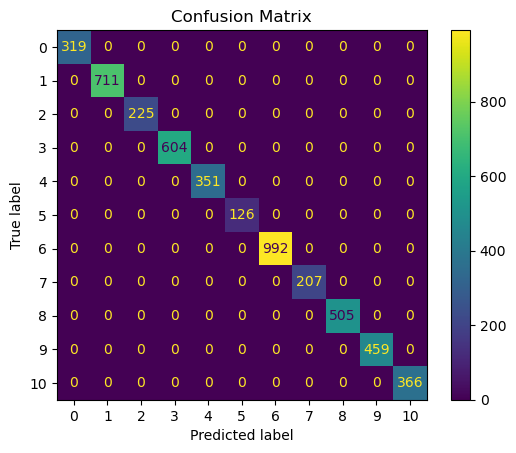

In [52]:
# Heat diffusion
from sknetwork.classification import DiffusionClassifier

classifier = DiffusionClassifier()

labels_pred = classifier.fit_predict(adjacency, labels)

train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

cm = confusion_matrix(labels_true[mask_train], labels_pred[mask_train])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix')
plt.show()

Train accuracy: 0.8110996916752312
Test accuracy: 0.8010104935872522


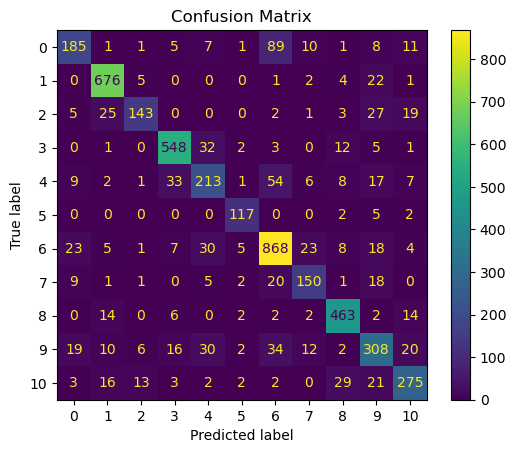

In [53]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(features[mask_train], labels[mask_train])
labels_pred = classifier.predict(features)

train_acc = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
test_acc = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

cm = confusion_matrix(labels_true[mask_train], labels_pred[mask_train])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix')
plt.show()